In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import random

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Wed Nov 25 13:52:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import skimage.transform as skt
input_data = []
label_data = []
folders_dir = "/content/drive/My Drive/facades/facades"
for folder_ in os.listdir(folders_dir):
    folder_dir = os.path.join(folders_dir, folder_)
    for data_dir in os.listdir(folder_dir):
        data = plt.imread(os.path.join(folder_dir, data_dir))
        input_data.append(skt.resize(data[:, :256, :], (275, 275)))
        label_data.append(skt.resize(data[:, 256:, :], (275, 275)))


In [ ]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self):
        self.input_data = input_data
        self.label_data = label_data

    def __len__(self):
        return len(self.input_data)
   
    def __getitem__(self, idx):
        input = self.input_data[idx]
        label = self.label_data[idx]
        lu_x = np.random.randint(0, 275 - 256)
        lu_y = np.random.randint(0, 275 - 256)
        input = input[lu_y:lu_y + 256, lu_x:lu_x + 256, :]
        label = label[lu_y:lu_y + 256, lu_x:lu_x + 256, :]
        if np.random.rand() > 0.5:
            input = np.flip(input, axis=1).copy()
            label = np.flip(label, axis=1).copy()
        input = torch.from_numpy(input.transpose((2, 0, 1))).float()
        label = torch.from_numpy(label.transpose((2, 0, 1))).float()
        input = (input - 0.5) / 0.5
        label = (label - 0.5) / 0.5
        return input, label

    def gettest(self, idx):
        input = skt.resize(self.input_data[idx], (256, 256))
        label = skt.resize(self.label_data[idx], (256, 256))
        input = torch.from_numpy(input.transpose((2, 0, 1))).float()
        label = torch.from_numpy(label.transpose((2, 0, 1))).float()
        input = (input - 0.5) / 0.5
        label = (label - 0.5) / 0.5
        return input, label

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels=3,   out_channels=64,  kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=True),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc2 = nn.Sequential(
            nn.Conv2d(in_channels=64,  out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc8 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)
        self.drop1 = nn.Dropout2d(0.5)

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)
        self.drop2 = nn.Dropout2d(0.5)

        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)
        self.drop3 = nn.Dropout2d(0.5)

        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 512, out_channels=256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 256, out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 128, out_channels=64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 64, out_channels=3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=True),
            nn.Tanh()
        ).to(device)



    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        enc6 = self.enc6(enc5)
        enc7 = self.enc7(enc6)
        enc8 = self.enc8(enc7)

        dec = self.dec1(enc8)
        dec = self.dec2(torch.cat([self.drop1(dec), enc7], dim=1))
        dec = self.dec3(torch.cat([self.drop2(dec), enc6], dim=1))
        dec = self.dec4(torch.cat([self.drop3(dec), enc5], dim=1))
        dec = self.dec5(torch.cat([dec, enc4], dim=1))
        dec = self.dec6(torch.cat([dec, enc3], dim=1))
        dec = self.dec7(torch.cat([dec, enc2], dim=1))
        dec = self.dec8(torch.cat([dec, enc1], dim=1))
        return dec


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3 + 3,   64,  kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,  128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1,   kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        ).to(device)
    
    def forward(self, X):
        return self.net(X)


In [ ]:
dataset = DataSet()
mbsz = 4
loader = DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)
D = Discriminator()
G = Generator()
D_solver = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [ ]:
lambda_dist = 10
train_L1loss = []
train_D_true = []
train_D_fake = []

In [ ]:
G.train()
for epoch in range(50):
    train_L1loss.append(0.0)
    train_D_true.append(0.0)
    train_D_fake.append(0.0)
    for _, (input, label) in enumerate(loader):
        
        input = input.to(device)
        label = label.to(device)

        D_solver.zero_grad()
        D_true = D(torch.cat([input, label], dim=1))
        D_fake = D(torch.cat([G(label).detach(), label], dim=1))
        D_true_loss = (D_true - 1.0).pow(2)
        D_fake_loss = D_fake.pow(2)
        (D_true_loss + D_fake_loss).mean().backward()
        D_solver.step()

        G_solver.zero_grad()
        input_fake = G(label)
        G_adv = (D(torch.cat([input_fake, label], dim=1)) - 1.0).pow(2).mean()
        L1_dist = torch.abs(input_fake - input).mean()
        (G_adv + lambda_dist * L1_dist).backward()
        G_solver.step()

        train_L1loss[-1] += L1_dist.item()
        train_D_true[-1] += D_true.mean().item()
        train_D_fake[-1] += D_fake.mean().item()
    train_L1loss[-1] /= len(loader)
    train_D_true[-1] /= len(loader)
    train_D_fake[-1] /= len(loader)
    print(train_L1loss[-1], train_D_true[-1], train_D_fake[-1])



0.25435075104631333 0.8425754792248177 0.15635795402186398
0.252409171485743 0.8409187454261527 0.15830481446823044
0.2560176888838509 0.8479630581985246 0.14965952355846368
0.2541975330635412 0.8437376085496107 0.15620866238404782
0.25193436729986934 0.846937409102522 0.15355714699808534
0.2511136829853058 0.8344049242553332 0.16745370018931216
0.251922842090493 0.8354222162669858 0.16150220512529675
0.25309694119241855 0.8407891570337561 0.15915607970318948
0.25242883647909226 0.8424558677025978 0.1552231613768647
0.25143218198359407 0.8369517248395263 0.16292115930924253
0.2498526248513468 0.8446944863196241 0.1563600056545673
0.24974999048851973 0.8432647972706927 0.15930883109643562
0.25076544294688874 0.8421332246025667 0.15694983326367393
0.24997321254764962 0.8498654087252965 0.14944358864515428
0.24867665718328083 0.836381286777408 0.16215589167611882
0.25011887189173543 0.832216565182667 0.1687426131298852
0.25042828542507245 0.8567731056781794 0.14311694506777833
0.250012980

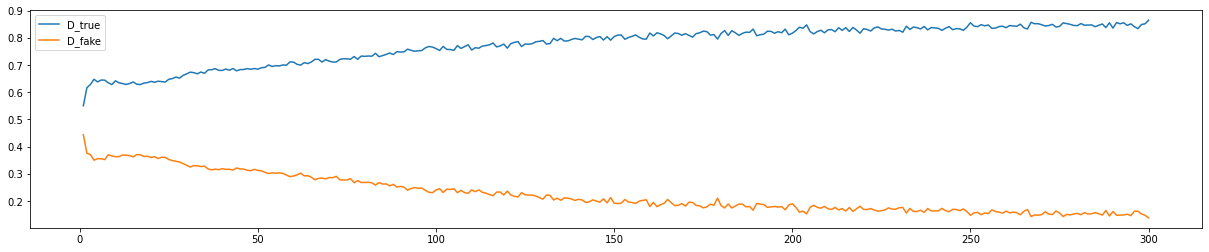

In [ ]:
plt.figure(figsize=(21, 4))
plt.plot(np.arange(1, len(train_D_true) + 1), train_D_true, label='D_true')
plt.plot(np.arange(1, len(train_D_fake) + 1), train_D_fake, label='D_fake')
plt.legend()
plt.show()

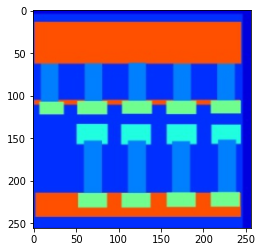

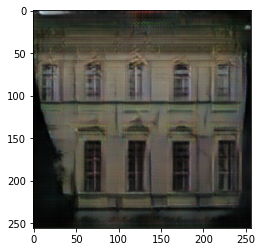

In [ ]:
G.eval()
input, label = dataset.gettest(555)
plt.figure(figsize=(4, 4))
plt.imshow((label.permute(1, 2, 0) +  1.0) * 0.5)
plt.show()

label = label.to(device).unsqueeze(0)
fake_input = G(label).cpu().detach()
fake_input = (fake_input.squeeze(0).permute(1, 2, 0) + 1.0) * 0.5
plt.figure(figsize=(4, 4))
plt.imshow(fake_input)
plt.show()

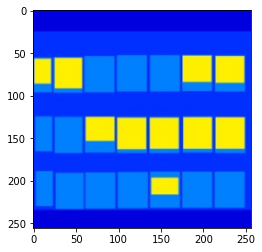

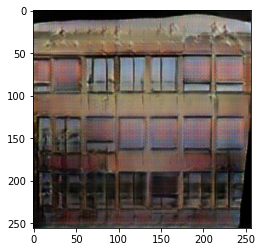

In [ ]:
G.eval()
input, label = dataset.gettest(211)
plt.figure(figsize=(4, 4))
plt.imshow((label.permute(1, 2, 0) +  1.0) * 0.5)
plt.show()
label = label.to(device).unsqueeze(0)
fake_input = G(label).cpu().detach()
fake_input = (fake_input.squeeze(0).permute(1, 2, 0) + 1.0) * 0.5
plt.figure(figsize=(4, 4))
plt.imshow(fake_input)
plt.show()


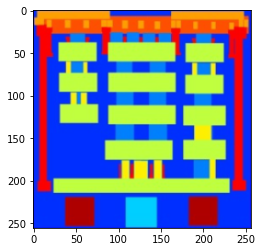

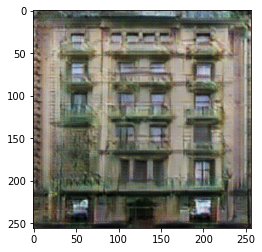

In [ ]:
G.eval()
input, label = dataset.gettest(333)
plt.figure(figsize=(4, 4))
plt.imshow((label.permute(1, 2, 0) +  1.0) * 0.5)
plt.show()
label = label.to(device).unsqueeze(0)
fake_input = G(label).cpu().detach()
fake_input = (fake_input.squeeze(0).permute(1, 2, 0) + 1.0) * 0.5
plt.figure(figsize=(4, 4))
plt.imshow(fake_input)
plt.show()
